In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import pandas as pd
#import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn import decomposition as skdecomp
from sklearn import ensemble as skensemble
from sklearn import tree as sktree
from sklearn import metrics as skmetrics

import os
import time
import matplotlib.pyplot as plt



In [2]:
#
# Prepare the data
#

train = pd.read_csv('train.csv')

# get the labels
y = train.target.values
train.drop(['id', 'target'], inplace=True, axis=1)

x = train.values

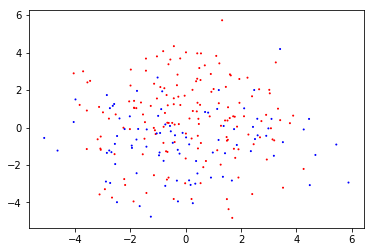

In [3]:
pca = skdecomp.PCA(n_components=2)
pca.fit(x)
coords = pca.transform(x)

color_sequence = []
for value in y:
    if value == 0:
        col = "b"
    else:
        col = "r"
    color_sequence.append(col)

plt.figure()
plt.scatter(coords[:,0], coords[:,1], s=1, c=color_sequence)

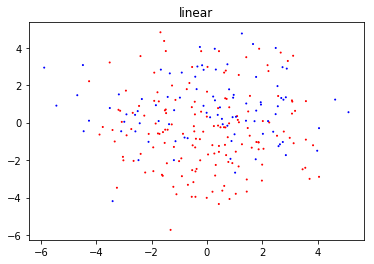

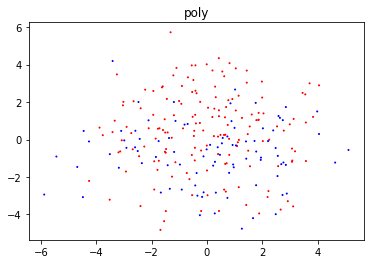

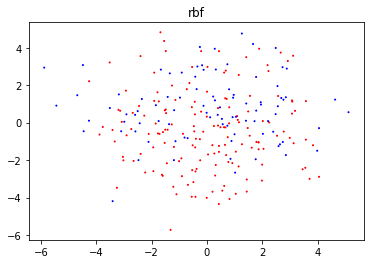

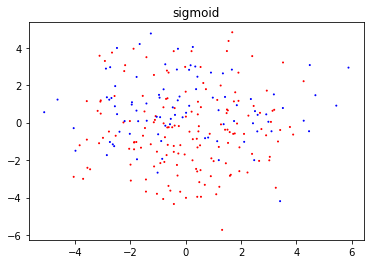

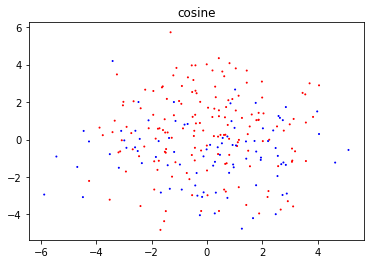

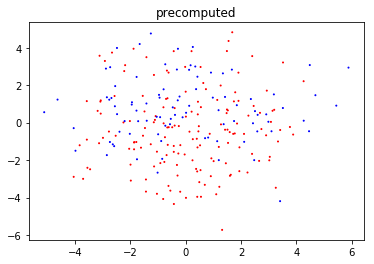

In [4]:
kernels_list = ["linear", "poly", "rbf", "sigmoid", "cosine", "precomputed"]

for kernel in kernels_list:
    pca = skdecomp.KernelPCA(n_components=2)
    pca.fit(x)
    coords = pca.transform(x)

    color_sequence = []
    for value in y:
        if value == 0:
            col = "b"
        else:
            col = "r"
        color_sequence.append(col)

    plt.figure()
    plt.scatter(coords[:,0], coords[:,1], s=1, c=color_sequence)
    plt.title(kernel)

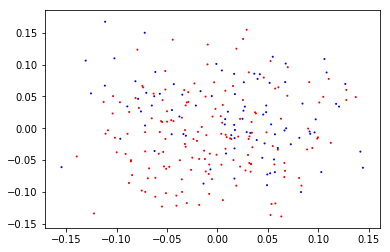

In [5]:
ica = skdecomp.FastICA(n_components=2)
ica.fit(x)
coords = ica.transform(x)

color_sequence = []
for value in y:
    if value == 0:
        col = "b"
    else:
        col = "r"
    color_sequence.append(col)

plt.figure()
plt.scatter(coords[:,0], coords[:,1], s=1, c=color_sequence)

Attempt at Fitting
==============

Use ICA to decouple any entangled signals, and then use the weighted random forest

In [62]:
n_zeros = np.shape(np.where(y == 0))[1]
n_ones = np.shape(np.where(y == 1))[1]
print("zeros: %d, ones: %d" % (n_zeros, n_ones))

zeros: 90, ones: 160


In [75]:
class WeightedPredictionEnsemble(skensemble.BaggingClassifier):

    def __init__(self, **kwargs):
        self.weight_one = kwargs.pop("weight_one", 1) #default value is 1
        super(WeightedPredictionEnsemble, self).__init__(**kwargs)

    def predict(self, X):
        weight_sum = np.zeros(np.shape(X)[0])
        avg_prediction = np.zeros(np.shape(X)[0])
        for clf in self.estimators_:
            results = clf.predict(X)
            results = results.astype(float)
            
            weight_sum[np.where(results == 0)] += 1
            weight_sum[np.where(results == 1)] += self.weight_one

            results[np.where(results == 1)] *= self.weight_one
            avg_prediction += results

        final = avg_prediction / weight_sum
        final[np.where(final >= 0.5)] = 1
        final[np.where(final < 1)] = 0

        return final

In [76]:
decoupling = skdecomp.FastICA(n_components=100)
decoupling.fit(x)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=100, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [77]:
# split the data into a train and validation set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y) 

In [78]:
# Without ICA Decoupling
random_forest = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=20, class_weight={0:1,1:0.56}), 
                                           n_estimators=1000, max_samples=200, weight_one=0.56)
random_forest.fit(x_train, y_train)
y_predicted = random_forest.predict(x_test)

score = skmetrics.accuracy_score(y_test, y_predicted)

print("Validation Score: %f" % score)

Validation Score: 0.660000


In [79]:
# With ICA Decoupling
random_forest = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=20), 
                                           n_estimators=1000, max_samples=200)
random_forest.fit(decoupling.transform(x_train), y_train)
y_predicted = random_forest.predict(decoupling.transform(x_test))

score = skmetrics.accuracy_score(y_test, y_predicted)

print("Validation Score: %f" % score)

Validation Score: 0.640000


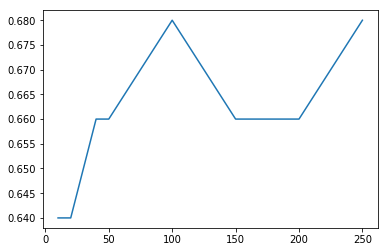

In [80]:
# cross Validate:
max_features_list = [10, 20, 40, 50, 100, 150, 200, 250]
vscores = []
for mf in max_features_list:
    random_forest = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=mf), 
                                               n_estimators=300, max_samples=200)
    random_forest.fit(x_train, y_train)
    y_predicted = random_forest.predict(x_test)

    score = skmetrics.accuracy_score(y_test, y_predicted)
    vscores.append(score)

plt.figure()
plt.plot(max_features_list, vscores)

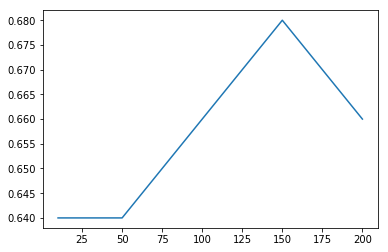

In [81]:
# cross Validate:
max_samples_list = [10, 50, 100, 150, 200]
vscores = []
for ms in max_samples_list:
    random_forest = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=300), 
                                               n_estimators=300, max_samples=ms)
    random_forest.fit(x_train, y_train)
    y_predicted = random_forest.predict(x_test)

    score = skmetrics.accuracy_score(y_test, y_predicted)
    vscores.append(score)

plt.figure()
plt.plot(max_samples_list, vscores)

In [82]:
# Without ICA Decoupling and after cross validation
random_forest = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=300, class_weight={0:1,1:0.56}), 
                                           n_estimators=1000, max_samples=150, weight_one=0.56)
random_forest.fit(x_train, y_train)
y_predicted = random_forest.predict(x_test)

score = skmetrics.accuracy_score(y_test, y_predicted)

print("Validation Score: %f" % score)

Validation Score: 0.740000


In [83]:
trained_random_forest = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=300, class_weight={0:1,1:0.56}), 
                                           n_estimators=1000, max_samples=150, weight_one=0.56)
trained_random_forest.fit(x,y)

WeightedPredictionEnsemble()

In [84]:
#
# Create a submission
#

submission = pd.read_csv('test.csv')
ids = submission['id'].values
submission.drop('id', inplace=True, axis=1)


x_submit = submission.values
y_submit = trained_random_forest.predict(x_submit)

n_zeros = np.shape(np.where(y_submit == 0))[1]
n_ones = np.shape(np.where(y_submit == 1))[1]
print("zeros: %d, ones: %d" % (n_zeros, n_ones))

output = pd.DataFrame({'id': ids, 'target': y_submit})
output.to_csv("submission_rf.csv", index=False)

zeros: 8583, ones: 11167
